# Build an amorphous homopolymer geometry using EMC.
Copyright ENEOS Corporation as contributors to Matlantis contrib project

Enhanced Monte Carlo\
https://montecarlo.sourceforge.net/emc/Welcome.html \
https://matsci.org/c/emc/50

P.J. in 't Veld and G.C. Rutledge, Macromolecules 2003, 36, 7358

In [1]:
import os
import sys
import numpy as np

from ase import Atoms, units
from ase.io import read, write, Trajectory
from ase.data import atomic_masses

from rdkit import Chem
from rdkit.Chem import AllChem, Draw


In [2]:
from pfcc_extras.visualize.view import view_ngl
from pfcc_extras.structure.ase_rdkit_converter import smiles_to_atoms, atoms_to_smiles

In [3]:
sys.path.insert(0, 'EMC_interface/src/emc_interface')
from emc_interface import EMCInterface

outputdir = './output'
os.makedirs(outputdir, exist_ok=True)

In [4]:
def set_elements_lammpsdata(atoms):
    mass_number = {int(np.round(m)):i for i, m in enumerate(atomic_masses)}
    masses = atoms.get_masses()
    numbers = [mass_number[int(np.round(m))] for m in masses] 
    atoms.numbers=numbers
    return atoms

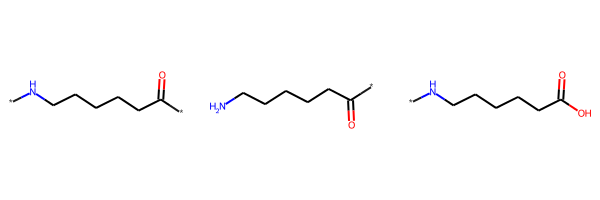

In [5]:
smiles_center = '*NCCCCCC(=O)*'
smiles_left = 'NCCCCCC(=O)*'
smiles_right = '*NCCCCCC(=O)O'
mols = [Chem.MolFromSmiles(smiles) for smiles in [smiles_center, smiles_left, smiles_right]]
view = Draw.MolsToGridImage(mols)
display(view)

settings = dict(
            smiles_center = smiles_center,
            smiles_left = smiles_left,
            smiles_right = smiles_right,
            ntotal = 2000,  # Number of atoms in the cell.
            density = 0.85, # Set slightly small density [g/cm3].
            field='pcff',
            ring_depth = 9,  #'auto', The max ring size in the molecules.
            build_dir = './build',
            lammps_prefix = 'Nylon6',
            project='homopolymer',
            seed=12345,
            repeat_center=8,  # 10 monomers with center + left + right 
)


### Comfirm the polymer structure.

In [6]:
ntotal, settings['ntotal'] = settings['ntotal'], 200

builder = EMCInterface()
builder.verbose  =True
builder.setup('homopolymer', **settings)
builder.build()



basename =  f'{builder.settings["project"]}'
atoms = read(f'{basename}.pdb')
print(f'Number of atoms: {len(atoms)} (< {settings["ntotal"]})')
settings['ntotal'] = ntotal

view_ngl([atoms], replace_structure=True)


{'center': '*NCCCCCC(=O)*', 'left': 'NCCCCCC(=O)*', 'right': '*NCCCCCC(=O)O', 'field': 'pcff', 'ntotal': 200, 'density': 0.85, 'ring_depth': 9, 'build_dir': './build', 'lammps_prefix': 'Nylon6', 'project': 'homopolymer', 'seed': 12345, 'emc_execute': 'false', 'repeat_center': 8, 'repeat_left': 1, 'repeat_right': 1}
EMC Setup v4.1.3 (April 7, 2022), (c) 2004-2022 Pieter J. in 't Veld

Info: reading script from "./setup.esh"
Info: phase1 = {poly}
Info: project = homopolymer
Info: ntotal = 200
Info: direction = x
Info: shape = 1
Info: force field type = "cff"
Info: force field name = "EMC_interface/EMC/v9.4.4/field/pcff/pcff"
Info: force field location = "."
Info: build for LAMMPS script in "./build"
Info: creating EMC build script "build.emc"
Info: assuming mol fractions
Info: creating LAMMPS run script "homopolymer.in"
Info: adding pressure sampling



(* EMC: Enhanced Monte Carlo simulations *)

version 9.4.4, build Jul 27 2022 17:22:21, date Thu Jan 19 05:48:03 2023

valid until Jul 2

## Build an amorphous polymer.

In [7]:
builder = EMCInterface()
builder.setup('homopolymer', **settings)

In [8]:
builder.build()

In [9]:
savedir = os.path.join(outputdir, f'build_{builder.settings["project"]}')
print(savedir)
builder.savefiles(savedir)

./output/build_homopolymer


In [10]:
basename =  f'{savedir}/{builder.settings["project"]}'
atoms_lammpsdata = read(f'{basename}.data', format='lammps-data')
atoms_lammpsdata = set_elements_lammpsdata(atoms_lammpsdata)
atoms = read(f'{basename}.pdb')

view_ngl([atoms, atoms_lammpsdata], replace_structure=True)

In [11]:
import importlib
MODEL_VERSION='latest'
CALC_MODE='CRYSTAL_PLUS_D3'
def get_calculator(model_version=MODEL_VERSION, calc_mode=CALC_MODE):

    spec = importlib.util.find_spec('pfp_api_client')
    if spec is None:
        from ase.calculators.emt import EMT
        calculator = EMT()
        return calculator

    from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
    from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode 
    if isinstance(calc_mode, str):
        calc_mode = getattr(EstimatorCalcMode, calc_mode)
    estimator = Estimator(model_version=model_version, calc_mode=calc_mode)
    calculator = ASECalculator(estimator)
    return calculator 

In [12]:
from ase.optimize import BFGS
atoms.calc = get_calculator()
opt = BFGS(atoms)
opt.run(steps=5)

/home/jovyan/.local/lib/python3.7/site-packages/pfp_api_client/__init__.py:36: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  f"New version of {package_name} is available. Please consider"


      Step     Time          Energy         fmax
BFGS:    0 05:51:31    -8479.187523        6.8700
BFGS:    1 05:52:41    -8514.551587        7.3324
BFGS:    2 05:53:54    -8533.127194        1.8286
BFGS:    3 05:55:47    -8547.817680        4.8026
BFGS:    4 05:58:24    -8558.064679        3.8680
BFGS:    5 06:01:01    -8563.869190        3.0698
BFGS:    6 06:03:32    -8568.395198        1.5837
BFGS:    7 06:06:13    -8573.110187        2.6834
BFGS:    8 06:09:07    -8575.676327        2.7998
BFGS:    9 06:11:59    -8578.495530        1.2605
BFGS:   10 06:14:56    -8580.898314        2.5518


False

In [13]:
view_ngl(opt.atoms)